In [3]:
from tqdm.auto import tqdm
from sentence_transformers import evaluation
import torch 
from transformers import BertModel
from transformers import BertTokenizer
from datasets import Dataset
import pandas as pd
from transformers.optimization import get_linear_schedule_with_warmup
import matplotlib.pyplot as plt 
import numpy as np
import sklearn.model_selection
import sklearn
from sentence_transformers import SentenceTransformer, InputExample, losses, util

In [4]:
#load data 
df = pd.read_csv("/shared/3/projects/benlitterer/localNews/NetworkMVP/enTrainData.csv", sep="\t")
df = df.loc[(df["url1_lang"] == "en") & (df["url2_lang"] == "en")]

#put ground truth values into a list 
df["ground_truth"] = df['Overall']

#TODO: do we need to make data tensors or does this happen when we call set_format() later on
#df["ground_truth"] = df["ground_truth"].apply(torch.tensor)

#[torch.tensor(gtList) for gtList in df["ground_truth"]]

#get only the columns we need 
#TODO: do we need "pair_id"? 
leanDf = df[["ground_truth",  'text1', 'text2']].dropna()


(array([593., 189., 113., 139.,  75.,  97., 111.,  71.,  91., 197.]),
 array([0.25 , 0.325, 0.4  , 0.475, 0.55 , 0.625, 0.7  , 0.775, 0.85 ,
        0.925, 1.   ]),
 <a list of 10 Patch objects>)

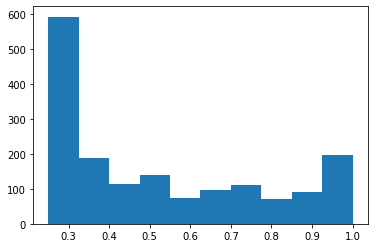

In [5]:
#check to make sure this is the right transformation to scale the data to (0, 1)
plt.hist((5 - leanDf["ground_truth"]) / 4)

In [6]:
#rescale data from (0, 4): (0, 1)
leanDf["ground_truth"] = (5 - leanDf["ground_truth"]) / 4

(array([593., 189., 113., 139.,  75.,  97., 111.,  71.,  91., 197.]),
 array([0.25 , 0.325, 0.4  , 0.475, 0.55 , 0.625, 0.7  , 0.775, 0.85 ,
        0.925, 1.   ]),
 <a list of 10 Patch objects>)

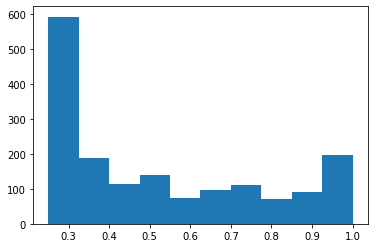

In [7]:
plt.hist(leanDf["ground_truth"])

In [8]:
print(df.shape)
print(len(df["link1"].unique()))
print(len(df["link2"].unique()))

(1690, 20)
1684
1510


In [9]:
deviceNum = 4
def check_mem():
    torch.cuda.empty_cache()
    a = torch.cuda.memory_allocated(deviceNum)/1024/1024/1024
    r = torch.cuda.memory_reserved(deviceNum)/1024/1024/1024
    print("torch.cuda.memory_allocated: %fGB"%a)
    print("torch.cuda.memory_reserved: %fGB"%r)
    print("torch.cuda.memory_free: %fGB"%(r-a))
    print("torch.cuda.max_memory_reserved: %fGB"%(torch.cuda.max_memory_reserved(deviceNum)/1024/1024/1024))
check_mem()

torch.cuda.memory_allocated: 0.000000GB
torch.cuda.memory_reserved: 0.000000GB
torch.cuda.memory_free: 0.000000GB
torch.cuda.max_memory_reserved: 0.000000GB


In [10]:
#split data 
trainDf, validDf = sklearn.model_selection.train_test_split(leanDf, train_size=.75, test_size=.25)
trainDf = trainDf.reset_index(drop=True)
trainDf.head(2)

,ground_truth,text1,text2
0,1.00,Federal judge to block latest North Carolina v...,"RALEIGH, N.C. — The federal judge who blocked ..."
1,0.25,Los Angeles police have arrested one of three ...,"Papy Sukami, the leader of one of the groups, ..."


In [11]:
print("Train Rows: " + str(trainDf.shape[0]))
print("Validation Rows: "  + str(validDf.shape[0]))

Train Rows: 1257
Validation Rows: 419


In [15]:
trainExamples = []
for row in trainDf.itertuples(): 
    trainExamples.append(InputExample(texts =[row[2], row[3]], label=row[1]))

In [18]:
#Define the model. Either from scratch of by loading a pre-trained model
#del model 
torch.cuda.empty_cache()

#del(model)

model = SentenceTransformer('all-mpnet-base-v2', device="cuda:" + str(deviceNum))

#Define your train examples. You need more than just two examples...
#train_examples = [InputExample(texts=['My first sentence', 'My second sentence'], label=0.8),
#    InputExample(texts=['Another pair', 'Unrelated sentence'], label=0.3)]

#Define your train dataset, the dataloader and the train loss
train_dataloader = torch.utils.data.DataLoader(trainExamples, shuffle=True, batch_size=5)

#works OK 
#train_loss = losses.MultipleNegativesRankingLoss(model)

train_loss = losses.CosineSimilarityLoss(model)

evaluator = evaluation.EmbeddingSimilarityEvaluator(list(validDf["text1"]), list(validDf["text2"]), list(validDf["ground_truth"]))

check_mem()

#Tune the model
#"/shared/3/projects/benlitterer/localNews/NetworkMVP/SBERTstockEval"
output_path = "/home/blitt/projects/localNews/models/sentEmbeddings/0.0-mpNetCosSim/output"
checkpoint_path = "/home/blitt/projects/localNews/models/sentEmbeddings/0.0-mpNetCosSim/checkpoint"
evaluation_steps = 50
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=1, warmup_steps=75, evaluator=evaluator, evaluation_steps = evaluation_steps, output_path=output_path, checkpoint_path=checkpoint_path, save_best_model=True)

torch.cuda.memory_allocated: 0.000000GB
torch.cuda.memory_reserved: 0.000000GB
torch.cuda.memory_free: 0.000000GB
torch.cuda.max_memory_reserved: 0.000000GB


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/252 [00:00<?, ?it/s]

In [19]:
evalData = pd.read_csv("/home/blitt/projects/localNews/models/sentEmbeddings/0.0-mpNetCosSim/output/eval/similarity_evaluation_results.csv")

In [20]:
evalData

,epoch,steps,cosine_pearson,cosine_spearman,euclidean_pearson,euclidean_spearman,manhattan_pearson,manhattan_spearman,dot_pearson,dot_spearman
0,0,50,0.840399,0.814732,0.858829,0.814732,0.858200,0.813662,0.840399,0.814732
1,0,100,0.855151,0.812112,0.864007,0.812112,0.864333,0.813016,0.855151,0.812112
2,0,150,0.859412,0.818508,0.866468,0.818508,0.866208,0.818351,0.859412,0.818508
3,0,200,0.863501,0.818953,0.867756,0.818953,0.867893,0.819543,0.863501,0.818953
4,0,250,0.865871,0.819856,0.868089,0.819856,0.868569,0.821336,0.865871,0.819856
5,0,-1,0.865879,0.819865,0.868098,0.819865,0.868578,0.821342,0.865879,0.819865
6,0,50,0.788063,0.745780,0.805616,0.745780,0.805632,0.746373,0.788063,0.745780
7,0,100,0.800953,0.752787,0.815589,0.752787,0.815243,0.750051,0.800953,0.752787
8,0,150,0.808117,0.760635,0.820086,0.760635,0.820097,0.759055,0.808117,0.760635
9,0,200,0.813175,0.759235,0.823868,0.759235,0.823745,0.755480,0.813175,0.759235


<ipython-input-21-af30dcb78274>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plotData["totalSteps"] = totalSteps


Text(0, 0.5, 'Pearson Correlation')

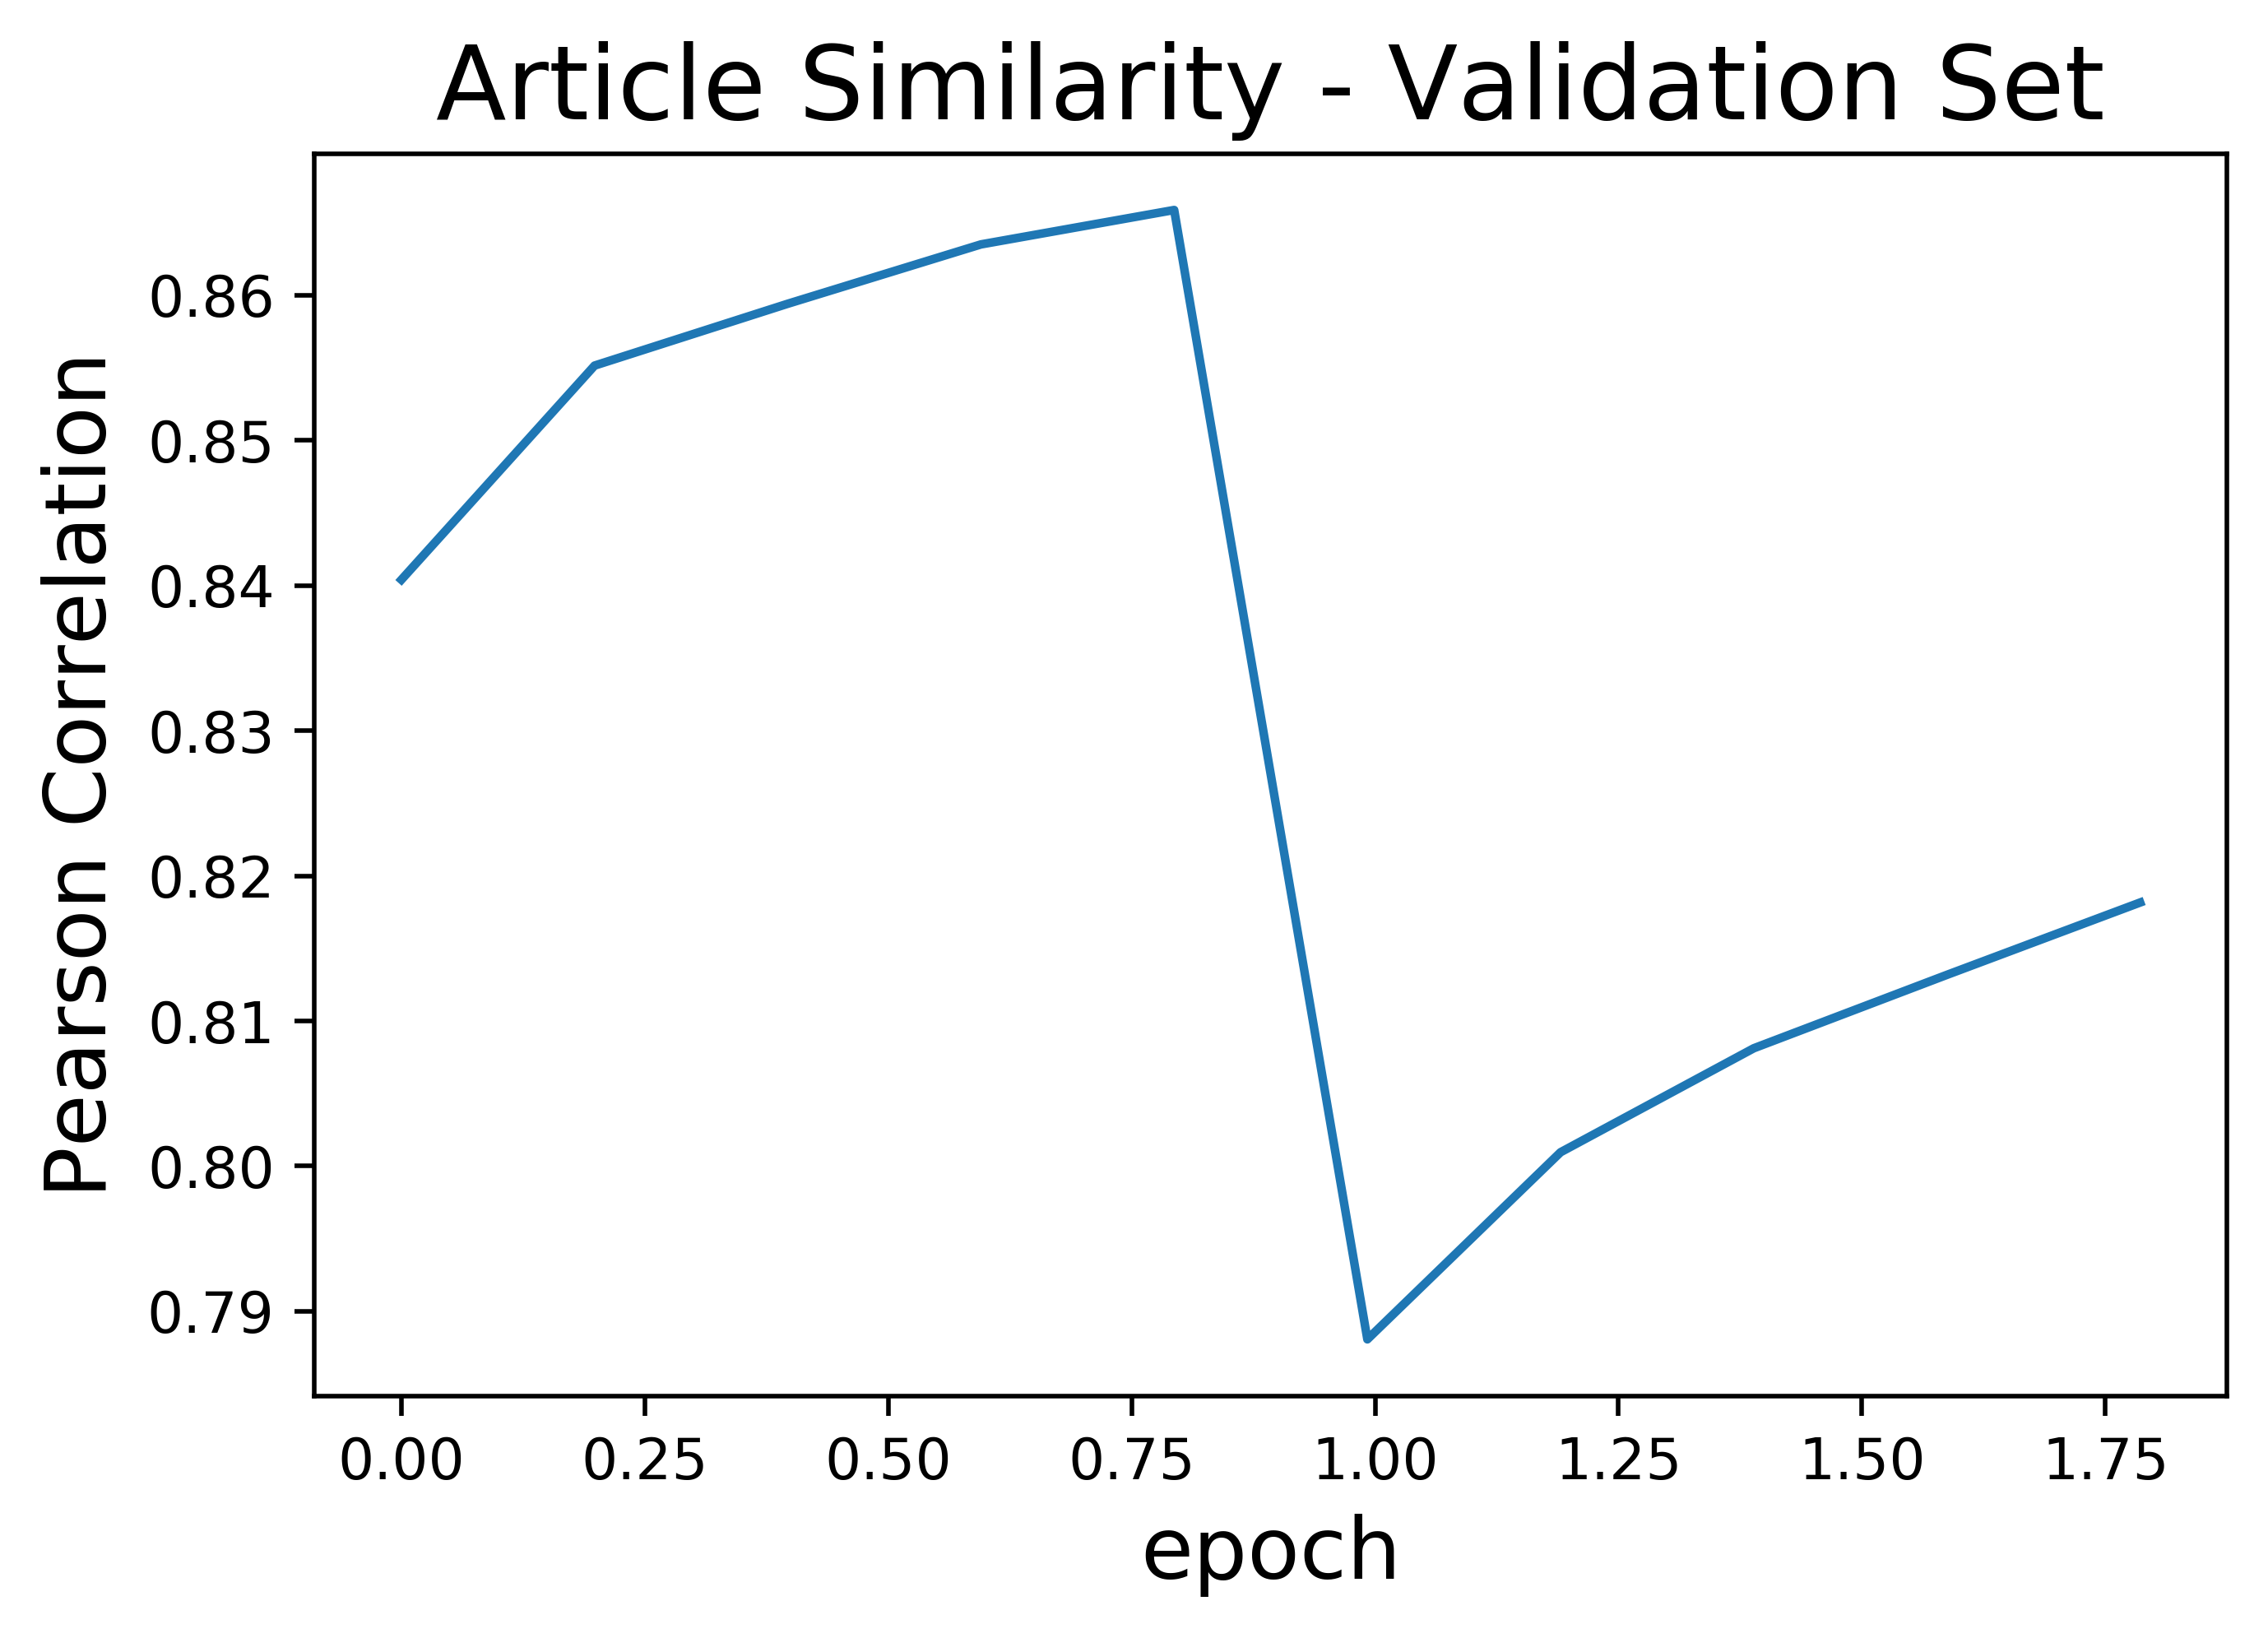

In [21]:
#format the data in dataframe 
plotData = evalData[evalData["steps"] != -1]
currStep = 0 
evaluation_steps = 50 
totalSteps = []
for i in range(len(plotData)):
    totalSteps.append(currStep)
    currStep += evaluation_steps 
    
plotData["totalSteps"] = totalSteps

#plot eval 
plt.rcParams['figure.dpi'] = 500
plt.plot(plotData["totalSteps"] / 252, plotData["cosine_pearson"])
plt.title("Article Similarity - Validation Set", size=18)
plt.xlabel("epoch", size=15)
plt.ylabel("Pearson Correlation", size=15)

In [72]:
#get test data 
testRow = validDf.reset_index(drop=True).iloc[0,:]
testExample = InputExample(texts = [testRow[1], testRow[2]], label=testRow[0])
testDf = pd.read_csv("/shared/3/projects/benlitterer/localNews/NetworkMVP/enTestData.csv", sep="\t")
testDf.head(1)
print(testDf.shape)

In [98]:
#load model
modelPath = "/home/blitt/projects/localNews/models/sentEmbeddings/0.0-mpNetCosSim/output"
model = SentenceTransformer(modelPath)

#compute embeddings for the test data and get correlation with ground truth 
text1 = list(testDf["text1"])
text2 = list(testDf["text2"])

#embed test text 
embed1 = model.encode(text1)
embed2 = model.encode(text2)

#get our cosine sims 
cos_scores = [] 
for i in range(len(embed1)): 
    cos_scores.append(util.cos_sim(embed1[i], embed2[i]))
cos_scores[:2]

#rescale ground truth 
preds = [float(item) for item in cos_scores]
gt = (5 - testDf["Overall"]) / 4
np.corrcoef([preds, gt])

#to dataframe 
comparisonMat = pd.DataFrame({"gt":gt, "preds":preds})

#create cutoff and get predictions/gt for binary classification problem 
cutoff = .6
comparisonMat["gtIsSame"] = comparisonMat["gt"] >= .8
comparisonMat["gtIsSame"] = comparisonMat["gtIsSame"].astype(int)

comparisonMat["predIsSame"] = comparisonMat["preds"] >= .8
comparisonMat["predIsSame"] = comparisonMat["predIsSame"].astype(int)
comparisonMat

,gt,preds,gtIsSame,predIsSame
0,0.375,0.164027,0,0
1,1.000,0.767520,1,0
2,0.250,0.221453,0,0
3,0.875,0.813381,1,1
4,0.250,0.249794,0,0
...,...,...,...,...
229,0.250,0.179649,0,0
230,1.000,0.799231,1,0
231,0.750,0.815019,0,1
232,0.750,0.735217,0,0


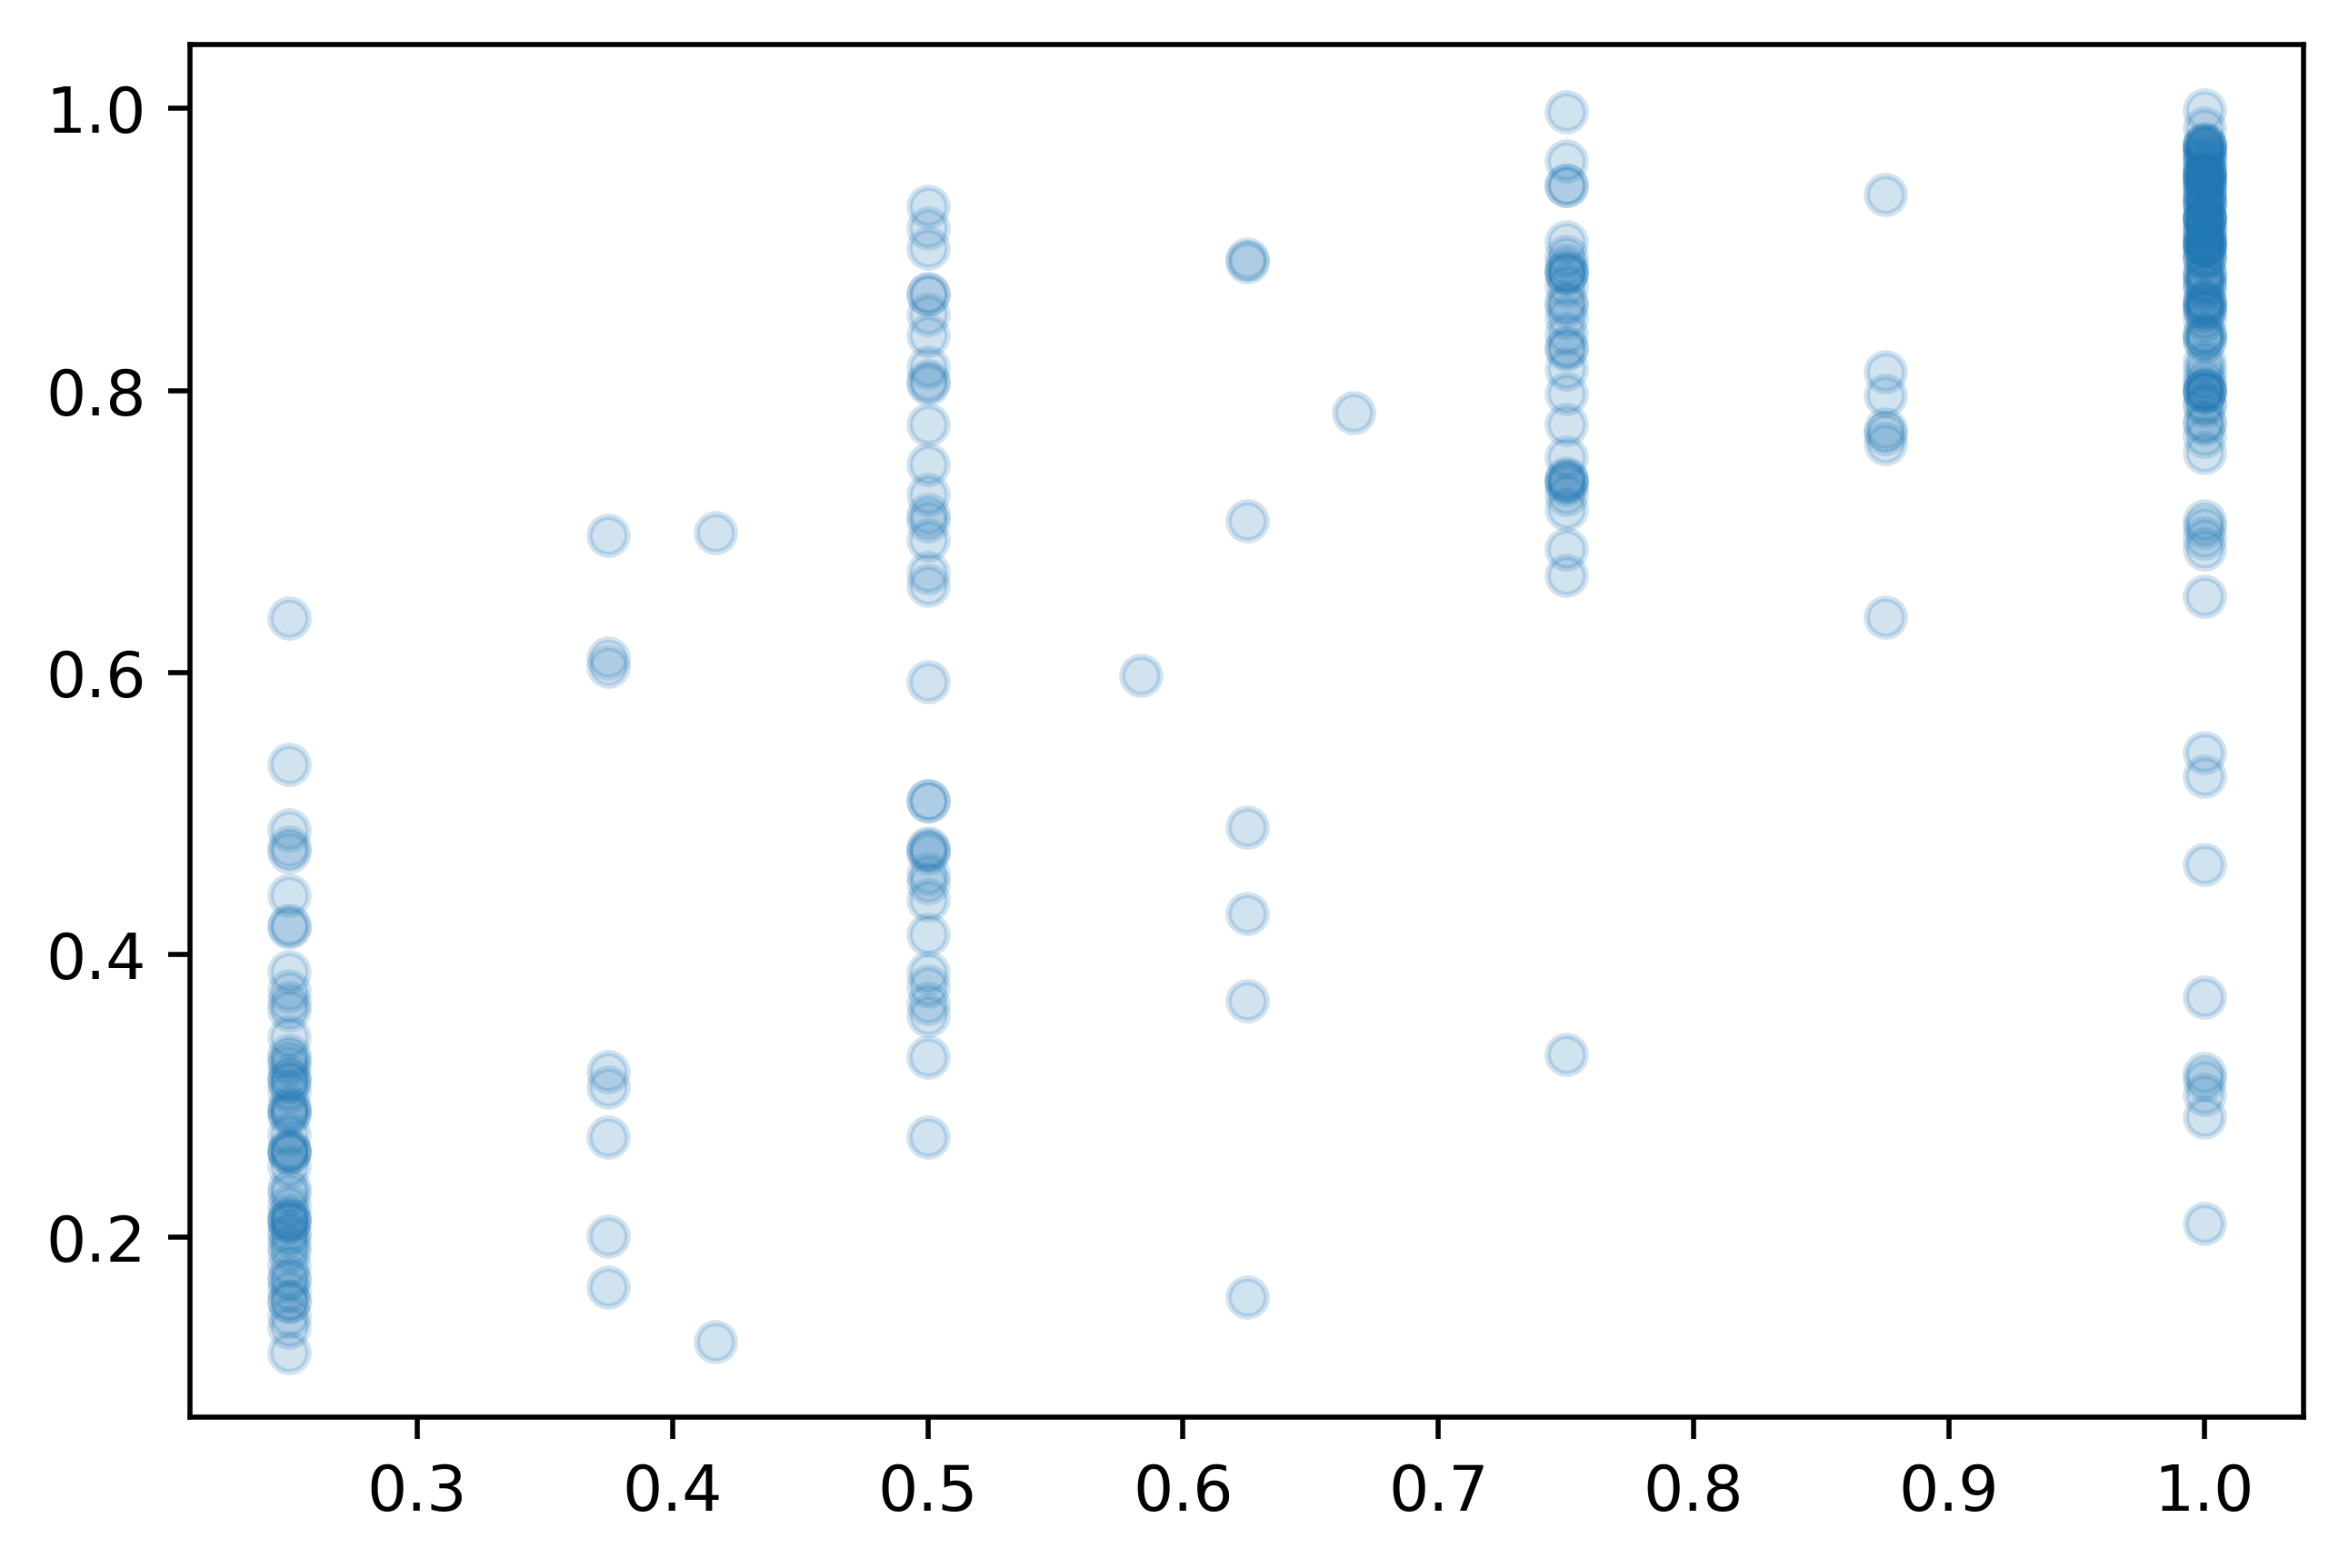

In [99]:
#compare ground truth on x axis to predictions on the y 
plt.scatter(comparisonMat["gt"], comparisonMat["preds"], alpha = .2)


In [1]:
fig, ax = plt.subplots(figsize=[5, 2])
plt.hist(comparisonMat["gt"])
plt.title("Ground Truth Distribution")
plt.xlim([0, 1])
plt.xlabel("Similarity")
plt.ylabel("Count")

NameError: name 'plt' is not defined

In [100]:
#confusion matrix 
conf = sklearn.metrics.confusion_matrix(comparisonMat["gtIsSame"], comparisonMat["predIsSame"])

#unpack conf matrix. Get accuracy 
acc = (conf[0,0] + conf[1, 1] ) / (len(comparisonMat))
tn, fp, fn, tp = conf.ravel()

#get precision, recall, f1
precision = (tp) / (tp + fp)
print("precision: " + str(precision))
recall = (tp) / (tp + fn)
print("recall: " + str(recall))
f1 = 2 * (precision * recall) / (precision + recall)
print("f1: " + str(f1))

precision: 0.7087378640776699
recall: 0.7227722772277227
f1: 0.7156862745098039
